In [1]:
import os
import ntpath
import shutil

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from typing import Callable

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train / 255
X_test = X_test / 255

In [3]:
def scheduler(drop_after: int) -> Callable[[int, int], float]:
    def drop(epoch: int, learning_rate: int) -> float:
        if epoch < drop_after:
            return learning_rate
        else:
            return learning_rate * tf.math.exp(-0.2)

    return drop


def get_callbacks(kind: str) -> (keras.callbacks.EarlyStopping, keras.callbacks.ModelCheckpoint, keras.callbacks.TensorBoard):
    the_name = f'denoising_autoencoder_{kind}'
    patience = 5
    model_dir = os.path.join(os.curdir, 'saved_models')
    run_logdir_root = os.path.join(os.curdir, 'tensor_logs')
    dirs = [
        name
        for name in os.listdir(run_logdir_root)
        if os.path.isdir(os.path.join(run_logdir_root, name)) and name.startswith(name)
    ]
    dirs_count = len(dirs) + 1
    run_logdir = os.path.join(run_logdir_root, f'{the_name}_{dirs_count}')
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, min_delta=1e-4)
    model_checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(model_dir, f'{the_name}_{dirs_count}.h5'), save_best_only=True)
    tensorboard = keras.callbacks.TensorBoard(run_logdir, histogram_freq=1, profile_batch=10)
    lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler(10))

    return early_stopping, model_checkpoint, tensorboard, lr_scheduler

In [4]:
def create_dropout_model(
        activation: str,
        upper_units: int,
        lower_units: int,
        optimizer_name: str = None,
        optimizer_obj: keras.optimizers.Optimizer = None) -> keras.models.Model:
    encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dropout(.5),
        keras.layers.Dense(upper_units, activation=activation),
        keras.layers.Dense(lower_units, activation=activation)
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(upper_units, activation=activation, input_shape=(lower_units,)),
        keras.layers.Dense(28 * 28, activation='sigmoid'),
        keras.layers.Reshape((28, 28))
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])

    autoencoder.compile(loss='binary_crossentropy', optimizer=optimizer_name or optimizer_obj,
                        metrics=['mse'])

    return autoencoder

In [34]:
def fit(autoencoder: keras.models.Model, kind: str):
    early_stopping, model_checkpoint, tensorboard, lr_scheduler = get_callbacks(kind)

    autoencoder.fit(
        X_train,
        X_train,
        epochs=10,
        validation_data=(X_test, X_test),
        callbacks=[early_stopping, model_checkpoint, tensorboard])


for activation in ['relu', 'selu']:
    for upper_units in [100, 200, 300]:
        for lower_units in [10, 20, 30, 40]:
            for optimizer_name in ['adam', 'rmsprop']:
                autoencoder = create_dropout_model(activation, upper_units, lower_units, optimizer_name)

                fit(autoencoder, 'dropout')

            for optimizer_obj in [keras.optimizers.Nadam()]:
                autoencoder = create_dropout_model(
                    activation,
                    upper_units,
                    lower_units,
                    optimizer_obj=optimizer_obj)

                fit(autoencoder, 'dropout')

In [9]:
def find_best_and_worst_models(kind: str) -> (keras.models.Model, keras.models.Model, float, float):
    best_mse = float('inf')
    best_loss = float('inf')
    worst_mse = -float('inf')
    worst_loss = -float('inf')
    autoencoders_info = {
        'best_model': None,
        'best_model_name': None,
        'worst_model': None,
        'worst_model_name': None
    }
    path = f'{os.getcwd()}/saved_models'
    model_paths = [
        f for f in os.listdir(path)
        if os.path.isfile(os.path.join(path, f)) and kind in os.path.join(path, f)]

    for name in model_paths:
        model = keras.models.load_model(f'{path}/{name}')
        loss, mse = model.evaluate(X_test, X_test)

        if loss < best_loss and mse < best_mse:
            best_loss = loss
            best_mse = mse
            autoencoders_info['best_model'] = model
            autoencoders_info['best_model_name'] = name
        if loss > worst_loss and mse > worst_mse:
            worst_loss = loss
            worst_mse = mse
            autoencoders_info['worst_model'] = model
            autoencoders_info['worst_model_name'] = name

    return \
        autoencoders_info['best_model'], \
        autoencoders_info['worst_model'], \
        autoencoders_info['best_model_name'], \
        autoencoders_info['worst_model_name'], \
        best_mse, \
        worst_mse


def remove_redundant_data(keep: list[str]):
    path = os.getcwd()
    models_path = os.path.join(path, 'saved_models')
    logs_path = os.path.join(path, 'tensor_logs')
    model_paths = [
        f for f in map(lambda p: os.path.join(models_path, p), os.listdir(models_path))
        if os.path.isfile(f) and not ntpath.basename(f) in keep]
    log_paths = [
        f for f in map(lambda p: os.path.join(logs_path, p), os.listdir(logs_path))
        if os.path.isdir(f) and not ntpath.basename(f) in list(map(lambda k: k.split('.')[0], keep))]

    for path in model_paths:
        os.remove(path)

    for path in log_paths:
        shutil.rmtree(path)

In [10]:
best_model, worst_model, best_model_name, worst_model_name, best_mse, worst_mse = find_best_and_worst_models('dropout')
best_result = best_model.predict(X_test) * 255
worst_result = worst_model.predict(X_test) * 255

313/313 [==============================] - 0s 1ms/step


In [11]:
def show_numbers(best_result: np.ndarray, worst_result: np.ndarray = None):
    plt.style.use('dark_background')

    fig = plt.figure(figsize=(16, 8))
    columns = 10
    rows = 3
    imgs = np.vstack([X_test[:10, :, :], best_result[:10, :, :]])

    if worst_result is not None:
        imgs = np.concatenate([imgs, worst_result[:10, :, :]])

    for i in range(1, columns * rows + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i - 1])

    plt.show()

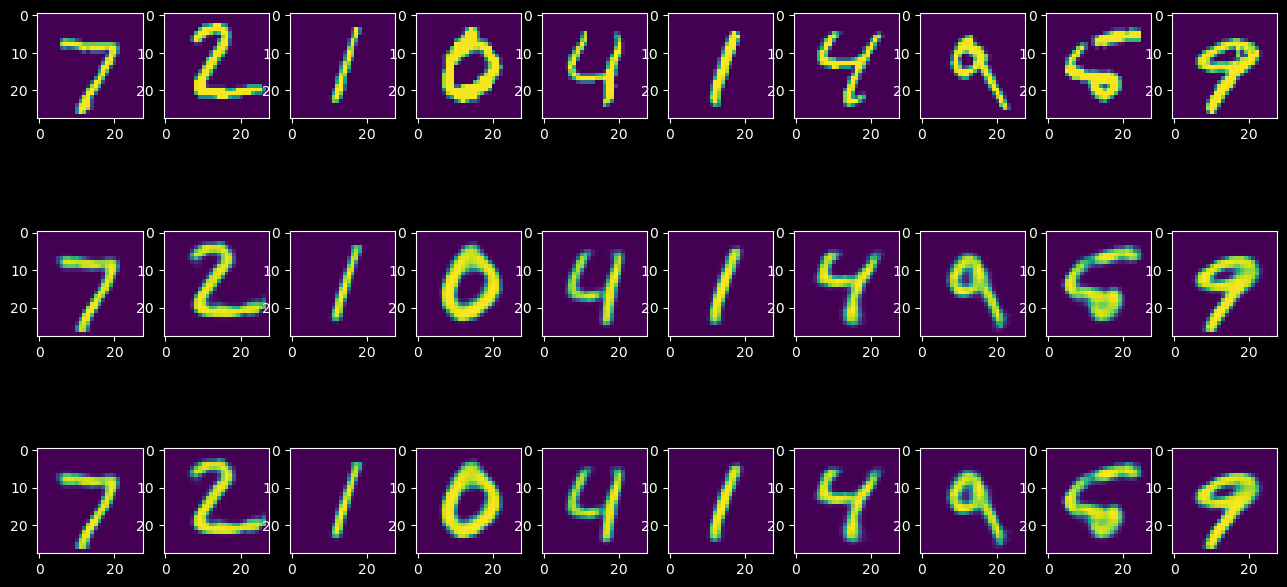

In [12]:
show_numbers(best_result, worst_result)

In [13]:
def create_noisy_model(
        noise: float,
        activation: str,
        upper_units: int,
        lower_units: int,
        optimizer_name: str = None,
        optimizer_obj: keras.optimizers.Optimizer = None) -> keras.models.Model:
    encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.GaussianNoise(noise),
        keras.layers.Dense(upper_units, activation=activation),
        keras.layers.Dense(lower_units, activation=activation)
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(upper_units, activation=activation, input_shape=(lower_units,)),
        keras.layers.Dense(28 * 28, activation='sigmoid'),
        keras.layers.Reshape((28, 28))
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])

    autoencoder.compile(loss='binary_crossentropy', optimizer=optimizer_name or optimizer_obj,
                        metrics=['mse'])

    return autoencoder

In [72]:
for noise_stddev in [.5, 1, 1.5]:
    for activation in ['relu', 'selu']:
        for upper_units in [100, 200, 300]:
            for lower_units in [10, 20, 30, 40]:
                for optimizer_name in ['adam', 'rmsprop']:
                    autoencoder = create_noisy_model(
                        noise_stddev,
                        activation,
                        upper_units,
                        lower_units,
                        optimizer_name)

                    fit(autoencoder, 'noise')

                for optimizer_obj in [keras.optimizers.Nadam()]:
                    autoencoder = create_noisy_model(
                        noise_stddev,
                        activation,
                        upper_units,
                        lower_units,
                        optimizer_obj=optimizer_obj)

                    fit(autoencoder, 'noise')

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1807 - mse: 0.0391 - val_loss: 0.1458 - val_mse: 0.0272
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1514 - mse: 0.0294 - val_loss: 0.1363 - val_mse: 0.0241
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1455 - mse: 0.0274 - val_loss: 0.1309 - val_mse: 0.0225
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1419 - mse: 0.0262 - val_loss: 0.1277 - val_mse: 0.0215
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1396 - mse: 0.0254 - val_loss: 0.1263 - val_mse: 0.0210
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1382 - mse: 0.0249 - val_loss: 0.1251 - val_mse: 0.0205
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1370 - mse: 0.0246 - val_loss: 0.1243 - val_mse: 0.0204
Epoch 8/10
1875/1875 [==============================] - 6s 3m

In [14]:
best_noisy_model, worst_noisy_model, best_noisy_model_name, worst_noisy_model_name, best_noisy_mse, worst_noisy_mse = find_best_and_worst_models('noise')
best_noisy_result = best_model.predict(X_test) * 255
worst_noisy_result = worst_model.predict(X_test) * 255

313/313 [==============================] - 0s 1ms/step


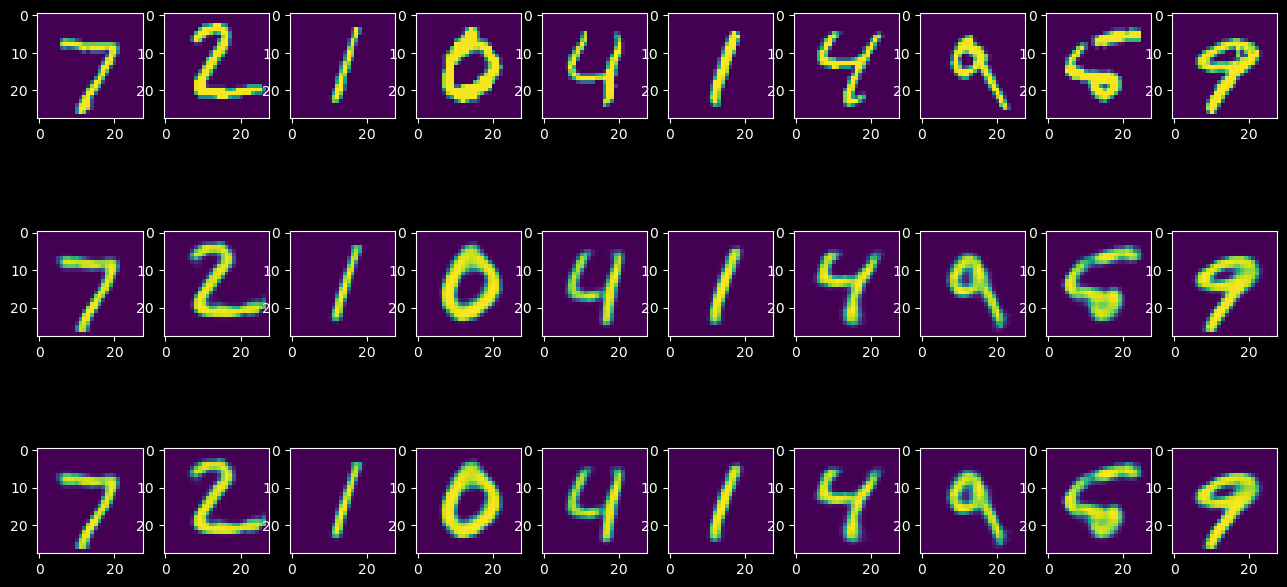

In [15]:
show_numbers(best_noisy_result, worst_noisy_result)

In [130]:
keep = [best_model_name, best_noisy_model_name]

remove_redundant_data([best_model_name, best_noisy_model_name])